In [353]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
import torch.utils.data
import torch.nn
import os
import math
import time
from matplotlib import pyplot as plot

# Проверка загруженных данных

In [354]:
dir_name = os.getcwd()
batch_size = 64

def show_images(images, title):
    num_showed_imgs_x = 7
    num_showed_imgs_y = 7

    figsize = (10, 10)
    fig, axes = plot.subplots(num_showed_imgs_y, num_showed_imgs_x, figsize = figsize)
    fig.suptitle(title)
    plot.setp(plot.gcf().get_axes(), xticks = [], yticks = [])
    for i, ax in enumerate(axes.flat):
        img = images[i][0].numpy().transpose(1, 2, 0).squeeze(axis = 2)
        ax.imshow(img, cmap = 'gray')



Number of train samples: 60000
Number of test samples: 10000


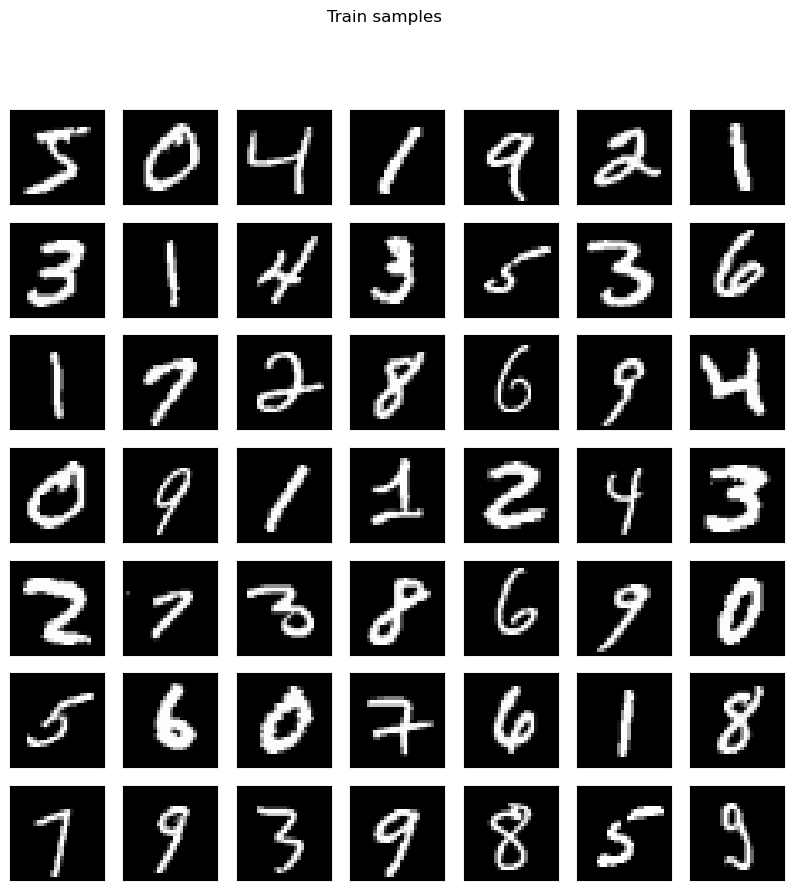

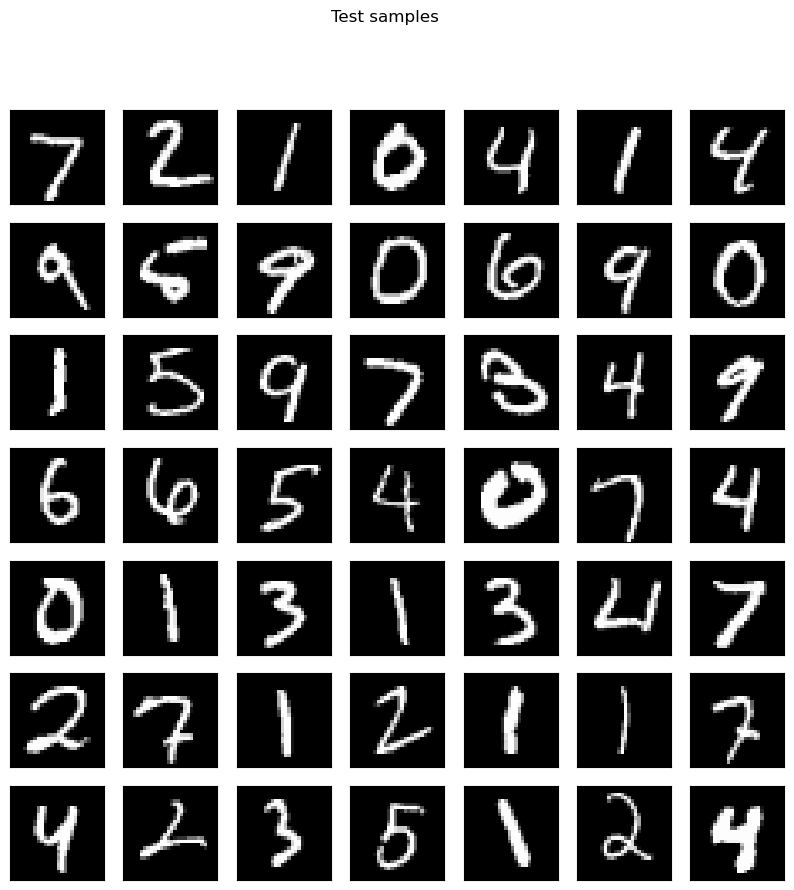

In [355]:
train_dataset = torchvision.datasets.MNIST(
    root = dir_name, train = True, download = True,
    transform = torchvision.transforms.ToTensor()
)
test_dataset = torchvision.datasets.MNIST(
    root = dir_name, train = False, download = True,
    transform = torchvision.transforms.ToTensor()
)

print('Number of train samples: {}'.format(len(train_dataset)))
show_images(train_dataset, 'Train samples')

print('Number of test samples: {}'.format(len(test_dataset)))
show_images(test_dataset, 'Test samples')

train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size = batch_size, shuffle = True
)
test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size = batch_size, shuffle = False
)

Обучающая выборка содержит 60000 примеров, размерность входных данных = 28*28, размерность выходных данных: 60000

In [356]:
print(train_dataset.data.shape)
print(train_dataset.targets.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


Тестовая выборка содержит 10000 примеров, размерность входных данных = 28*28, размерность выходных данных: 10000

In [357]:
print(test_dataset.data.shape)
print(test_dataset.targets.shape)

torch.Size([10000, 28, 28])
torch.Size([10000])


Первый семпл обучающей выборки:

In [358]:
train_dataset.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

Лейбл первого семпла обучающей выборки:

In [359]:
train_dataset.targets[0]

tensor(5)

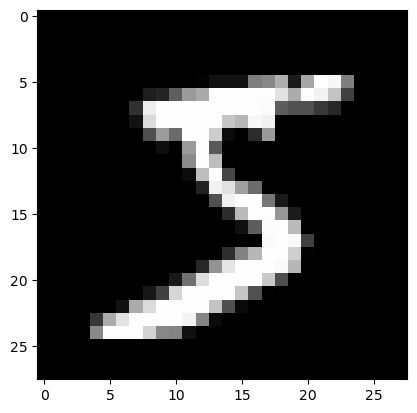

In [360]:
plot.imshow(train_dataset.data[0], cmap='gray')

# Основная часть

In [361]:
class TwoLayerNeuralNetwork(torch.nn.Module):
    
    def initialize_weights_and_biases(self):
        self.weights1 = torch.zeros(self.input_dim, self.hidden_dim)
        self.bias1 = torch.zeros(1, self.hidden_dim)
        
        self.weights2 = torch.zeros(self.hidden_dim, self.output_dim)
        self.bias2 = torch.zeros (1, self.output_dim)
        
        torch.nn.init.xavier_normal_(self.weights1)
        torch.nn.init.xavier_normal_(self.weights2)
        
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TwoLayerNeuralNetwork, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.initialize_weights_and_biases()
    
    def get_relu(self, x):
        r = torch.nn.ReLU()
        return r(x)
    
    def get_softmax(self, x):
        return torch.softmax(x, 1)
    
    def get_relu_derivative(self, x):
        return x > 0
        
    def forward(self, x):
        self.f = torch.matmul(x, self.weights1) + self.bias1
        self.v = self.get_relu(self.f)
        self.g = torch.matmul(self.v, self.weights2) + self.bias2
        self.u = self.get_softmax(self.g)
        return self.u

    def update_weights(self, dw1, dw2, learning_rate):
        self.weights1 -= learning_rate * dw1
        self.weights2 -= learning_rate * dw2
      
    def update_biases(self, db1, db2, learning_rate):
        self.bias1 -= learning_rate * db1
        self.bias2 -= learning_rate * db2

    def backward(self, x, y, learning_rate, batch_size):
        dz2 = (self.u - y) / batch_size
        dw2 = torch.matmul(self.v.transpose(0, 1), dz2)
        db2 = dz2.sum(0)

        dz1 = torch.mul(torch.matmul(dz2, self.weights2.transpose(0, 1)), self.get_relu_derivative(self.f))
        dw1 = torch.matmul(x.transpose(0, 1), dz1)
        db1 = dz1.sum(0)
        
        self.update_weights(dw1, dw2, learning_rate)
        self.update_biases(db1, db2, learning_rate)


In [362]:
w = 28
h = 28
image_resolution = w * h
s = 300
k = 10
epoches_num = 20
learning_rate = 0.1

neuralNetwork = TwoLayerNeuralNetwork(image_resolution, s, k)
neuralNetwork

TwoLayerNeuralNetwork()

In [363]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [364]:
def get_accuracy(data_loader, model):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.reshape(-1, image_resolution)
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(dim=0)
            tp += (predicted == labels).sum()
    return tp / n

def draw_epoch(i, accuracy, time):
    print('Epoch {}: Accuracy = {:.3f} %, Error = {:.3f}, Time = {:.4f}'.format(i, accuracy * 100, 1 - accuracy, time))

def train(learning_rate, batch_size):
    for epoch in range(epoches_num):
        t_start = time.time()
        for i, (images, labels) in enumerate(train_data_loader):
            images = images.view(-1, image_resolution).to(device)
            labels = labels.to(device)

            outputs = neuralNetwork.forward(images)
            
            labels_vect = torch.zeros(outputs.shape)
            for i in range(0, outputs.shape[0]):
                labels_vect[i, labels[i]] = 1
            
            neuralNetwork.backward(images, labels_vect, learning_rate, batch_size)
        t_finish = time.time()

        draw_epoch(epoch, get_accuracy(train_data_loader, neuralNetwork), t_finish - t_start)

# Проверка результатов

In [365]:
train(learning_rate, batch_size)

Epoch 0: Accuracy = 93.800 %, Error = 0.062, Time = 13.0064
Epoch 1: Accuracy = 95.930 %, Error = 0.041, Time = 13.4002
Epoch 2: Accuracy = 96.853 %, Error = 0.031, Time = 13.2418
Epoch 3: Accuracy = 97.498 %, Error = 0.025, Time = 14.0796
Epoch 4: Accuracy = 97.753 %, Error = 0.022, Time = 16.5385
Epoch 5: Accuracy = 98.208 %, Error = 0.018, Time = 15.5114
Epoch 6: Accuracy = 98.522 %, Error = 0.015, Time = 13.7288
Epoch 7: Accuracy = 98.598 %, Error = 0.014, Time = 14.7624
Epoch 8: Accuracy = 98.775 %, Error = 0.012, Time = 16.1094
Epoch 9: Accuracy = 98.972 %, Error = 0.010, Time = 14.4266
Epoch 10: Accuracy = 99.053 %, Error = 0.009, Time = 13.9243
Epoch 11: Accuracy = 99.233 %, Error = 0.008, Time = 13.8138
Epoch 12: Accuracy = 99.280 %, Error = 0.007, Time = 14.7419
Epoch 13: Accuracy = 99.427 %, Error = 0.006, Time = 15.7143
Epoch 14: Accuracy = 99.508 %, Error = 0.005, Time = 15.4439
Epoch 15: Accuracy = 99.592 %, Error = 0.004, Time = 15.2883
Epoch 16: Accuracy = 99.607 %, Err

Результаты работы на тестовой выборке:

In [366]:
test_accuracy = get_accuracy(test_data_loader, neuralNetwork)
print('Accuracy on test set = {:.3f} %, Error on test set = {:.3f}'.format(test_accuracy * 100, 1 - test_accuracy))

Accuracy on test set = 98.120 %, Error on test set = 0.019
